In [1]:
import numpy as np
import json

# we load the decks from London Mythic championship 
with open('london_db.json') as file:
    json_data = json.load(file)
    
cards_index = json_data['cards_index']
deck_list = json_data['deck_list']

# we just read the deck list
# decks = np.array(json_data['deck_list'])

# we transform the deck list by leaving only whether a given card occurs in the list
# decks = np.array([[int(bool(x)) for x in deck] for deck in json_data['deck_list']])

# the middle road, where we mostly care about whether the card is there (log)
# decks = np.array([[np.log(1+x) for x in deck] for deck in json_data['deck_list']])

# the middle road, where we mostly care about whether the card is there (by hand)
def scale(x):
    if x == 0 or x == 1:
        return x
    elif x == 2:
        return 1.5
    elif x == 3:
        return 1.8
    elif x == 4:
        return 2
    else:
        return 2.2
decks = np.array([[scale(x) for x in deck] for deck in json_data['deck_list']])
    

In [2]:
# constants related to different deck archetypes

ArchetypeList = ['Tron', 'Izzet Phoenix', 'Humans', 'W/U Control', 'Dredge', 
                 'Grixis Shadow', 'Eldrazi', 'Hardened Scales', 'Other']
ArchetypeIndex = { arch : ArchetypeList.index(arch) for arch in ArchetypeList }
ArchetypeColor = { 'Tron' : 'saddlebrown', 
                  'Izzet Phoenix' : 'orangered',
                  'Humans' : 'darkolivegreen',
                  'W/U Control' : 'steelblue',
                  'Dredge' : 'rebeccapurple',
                  'Grixis Shadow' : 'gold',
                  'Eldrazi' : 'goldenrod',
                  'Hardened Scales' : 'forestgreen',
                  'Other' : 'k' }
ArchetypeCards = [['Urza\'s Tower'], 
                  ['Arclight Phoenix'], 
                  ['Kitesail Freebooter'], 
                  ['Jace, the Mind Sculptor', 'Condemn'],
                  ['Narcomoeba', 'Stinkweed Imp'],
                  ['Death\'s Shadow'],
                  ['Eldrazi Temple'],
                  ['Hardened Scales'],
                  []]

def deck_archetype(deck):
    for i in range(len(ArchetypeList)):
        for c in ArchetypeCards[i]:
            if deck[cards_index.index(c)] != 0:
                return ArchetypeList[i]
    return 'Other'

arch_decks = { arch : np.array([deck for deck in decks if deck_archetype(deck) == arch]) for arch in ArchetypeList }

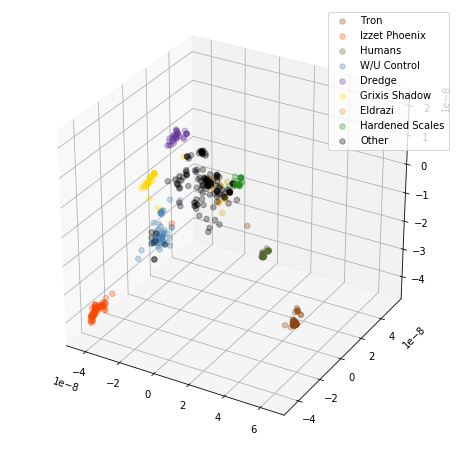

In [3]:
# rbf kernel PCA, 3-dimensional 
from sklearn.decomposition import KernelPCA

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

rbf_pca = KernelPCA(n_components = 3, kernel="rbf", gamma=1e-17*5.4)
rbf_pca.fit(decks)

transformed_decks = { arch : rbf_pca.transform(arch_decks[arch]) for arch in ArchetypeList}

plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

for arch in ArchetypeList:
    ax.scatter3D(transformed_decks[arch][:, 0], transformed_decks[arch][:, 1], transformed_decks[arch][:, 2], 'o', s=30, c=ArchetypeColor[arch], alpha=0.3, label=arch)
plt.legend()
plt.show()

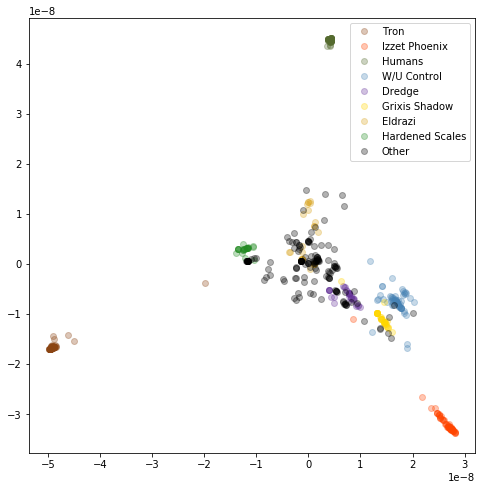

In [5]:
# rbf kernel PCA, 2-dimensional
import matplotlib.pyplot as plt
%matplotlib inline

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=1e-17*3)
rbf_pca.fit(decks)

transformed_decks = { arch : rbf_pca.transform(arch_decks[arch]) for arch in ArchetypeList}

plt.figure(figsize=(8,8))
for arch in ArchetypeList:
    if arch != 'Unknown':
        plt.plot(transformed_decks[arch][:, 0], transformed_decks[arch][:, 1], 'o', c=ArchetypeColor[arch], alpha=0.3, label=arch)
    else:
        plt.plot(transformed_decks[arch][:, 0], transformed_decks[arch][:, 1], 'o', c=ArchetypeColor[arch], alpha=0.2, label=arch)
        
plt.legend()
plt.show()

In [4]:
# looking for best parameters that help divide the decks into the known archetypes
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

decks_y = np.array([ArchetypeIndex[deck_archetype(deck)] for deck in decks])

clf = Pipeline([
            ("kpca", KernelPCA(n_components=2)),
            ("scaler", StandardScaler()),
            ("svm", SVC())
])
    
param_grid = [{
            "kpca__gamma": [1e-17, 1e-16, 1e-15],
            "kpca__kernel": ["rbf", "sigmoid"],
            "svm__gamma": [1e-17, 1e-16, 1e-14],
            "svm__kernel": ["rbf", "sigmoid"],
            "svm__C": [0.0001, 0.001, 0.01]
        }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(decks, decks_y)
grid_search.best_params_

{'kpca__gamma': 1e-17,
 'kpca__kernel': 'rbf',
 'svm__C': 0.0001,
 'svm__gamma': 1e-17,
 'svm__kernel': 'rbf'}